In [7]:
# Importing libraries
import argparse
import re
import os
import random
from glob import glob

from datasets import load_metric
from datasets import Dataset, DatasetDict
import numpy as np
import pandas as pd
from setproctitle import setproctitle
from tqdm import tqdm

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, EarlyStoppingCallback


# for kobert
# from kobert_tokenizer import KoBERTTokenizer
# from transformers import BertModel

import torch
import difflib as dl

import nltk
# nltk.download('punkt')
import string
from transformers import AutoTokenizer

parser = argparse.ArgumentParser()
# parser.add_argument('--dataset_path', default='/gec/data/v1.0/clean_data_v2_utf8.tsv')
# parser.add_argument('--dataset_path', default='/home/gec_sj/gec/data/v1.0/Korean_corpus_2021.csv')
# parser.add_argument('--north_phonetic_data_v1_path', default='/home/gec_sj/gec/data/v1.0/north_phonetic_corpus_v1.tsv')
# parser.add_argument('--north_phonetic_data_v2_path', default='/home/gec_sj/gec/data/v1.0/north_phonetic_corpus_v2.tsv')
# parser.add_argument('--modu_spelling_data_path', default='/home/gec_sj/gec/data/v1.0/modu_spelling_corpus_2021.tsv')
# parser.add_argument('--kspon_spelling_data_path', default='/home/gec_sj/gec/data/v1.0/kspon_spelling_corpus.tsv')

parser.add_argument('--dataset_format', default='tsv')
# parser.add_argument('--pretrained_model', default='KETI-AIR/ke-t5-large')
parser.add_argument('--pretrained_model', default='KETI-AIR/ke-t5-large-ko')
# parser.add_argument('--pretrained_model', default='skt/kobert-base-v1')
# parser.add_argument('--pretrained_model', default='google/mt5-large')
parser.add_argument('--seed', default=68)
parser.add_argument('--process_name', default='pko-5gram-t5-mario')
parser.add_argument('--batch_size', default=4)
parser.add_argument('--devices', default='3,2')
parser.add_argument('--data_limit', default=False)
parser.add_argument('--test_size_ratio', default=0.01)
parser.add_argument('--output_dir', default="./pko_save/pko-5gram/")
parser.add_argument('--max_input_length', default=96)
parser.add_argument('--min_input_length', default=5)
parser.add_argument('--max_target_length', default=96)
parser.add_argument('--min_target_length', default=5)

args = parser.parse_args(args=[])

random.seed(args.seed)

os.environ["WANDB_DISABLED"] = "true"

setproctitle(args.process_name)
## cuda device 설정
os.environ["CUDA_VISIBLE_DEVICES"]= args.devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)  # 출력결과: cuda 
print('Count of using GPUs:', torch.cuda.device_count())   #출력결과: 2 (2, 3 두개 사용하므로)
print('Current cuda device:', torch.cuda.current_device())  # 출력결과: 2 (2, 3 중 앞의 GPU #2 의미)

Device: cuda
Count of using GPUs: 2
Current cuda device: 0


In [8]:
# def align(inf_arr, lab_arr):
#     if len(inf_arr) == 0 and len(lab_arr) > 0:
#         inf_arr = lab_arr
#         return inf_arr, lab_arr
#     elif len(inf_arr) > 0 and len(lab_arr) == 0:
#         lab_arr = inf_arr
#         return inf_arr, lab_arr
                                  
#     # 추론 텍스트와 레이블 텍스트의 길이 차이에 따른 비교
#     if len(inf_arr) > len(lab_arr):
#         tmp_arr = []
#         tmp_arr.append(inf_arr[0] + inf_arr[1])
#         if len(inf_arr) >= 6: # overlapping 30%
#             tmp_arr.extend(inf_arr[5:])
#             inf_arr = tmp_arr
#         else:
#             inf_arr = tmp_arr
#     elif len(inf_arr) < len(lab_arr):
#         tmp_arr = []
#         tmp_arr.append(lab_arr[0] + lab_arr[1])
#         if len(lab_arr) >=6:
#             tmp_arr.extend(lab_arr[5:])
#             lab_arr = tmp_arr
#         else:
#             lab_arr = tmp_arr
#     elif len(inf_arr) == len(lab_arr):
#         return inf_arr, lab_arr
    
#     return align(inf_arr, lab_arr)

In [9]:
def align(inf_arr, lab_arr):
    if len(inf_arr) == 0 and len(lab_arr) > 0:
        inf_arr = lab_arr
        return inf_arr, lab_arr
    elif len(inf_arr) > 0 and len(lab_arr) == 0:
        lab_arr = inf_arr
        return inf_arr, lab_arr
                                  
    # 추론 텍스트와 레이블 텍스트의 길이 차이에 따른 비교
    if len(inf_arr) > len(lab_arr):
        tmp_arr = []
        tmp_arr.append(inf_arr[0] + inf_arr[1])
        if len(inf_arr) >= 3:
            tmp_arr.extend(inf_arr[2:])
            inf_arr = tmp_arr
        else:
            inf_arr = tmp_arr
    elif len(inf_arr) < len(lab_arr):
        tmp_arr = []
        tmp_arr.append(lab_arr[0] + lab_arr[1])
        if len(lab_arr) >= 3:
            tmp_arr.extend(lab_arr[2:])
            lab_arr = tmp_arr
        else:
            lab_arr = tmp_arr
    elif len(inf_arr) == len(lab_arr):
        return inf_arr, lab_arr
    
    return align(inf_arr, lab_arr)

In [10]:
def overlap20(text_arr):
    overlap_text_arr = []
    if len(text_arr) // 14 > 0:
        n = len(text_arr) // 14 + 1
    else:
        n = 1
        
    for i in range(n):
        if i == 0:
            tmp_res = text_arr[:20]
            overlap_text_arr.append(" ".join(tmp_res))
        else:
            if i != n - 1:
                tmp_res = text_arr[i * 14: i * 14 + 20]
                overlap_text_arr.append(" ".join(tmp_res))
            else:
                tmp_res = text_arr[i * 14:]
                overlap_text_arr.append(" ".join(tmp_res))  
        # print(tmp_res)

    return overlap_text_arr

In [11]:
# def overlap(text_arr):
#     overlap_text_arr = []
    
#     if len(text_arr) // 7 > 0:
#         n = len(text_arr) // 7
#     else:
#         n = 1
        
#     for w in range(n):
#         if w == 0:
#             tmp_res = text_arr[:10]
#             overlap_text_arr.append(" ".join(tmp_res))
#         else:
#             tmp_res = text_arr[w * 7: w * 7 + 10]
#             overlap_text_arr.append(" ".join(tmp_res))

#     return overlap_text_arr




def overlap2(text_arr): # 6gram
    overlap_text_arr = []
    
    if len(text_arr) // 3 > 0:
        n = len(text_arr) // 3
    else:
        n = 1
        
    for j in range(n):
        if j == 0:
            tmp_res = text_arr[:5]
            overlap_text_arr.append(" ".join(tmp_res))
        else:
            if j != n - 1:
                tmp_res = text_arr[j * 3: j * 3 + 5]
                overlap_text_arr.append(" ".join(tmp_res))
            else:
                tmp_res = text_arr[j * 3:]
                overlap_text_arr.append(" ".join(tmp_res))  
        # print(tmp_res)

    return overlap_text_arr

In [13]:
path = '/gec_s/s-kr/fine-tune/dataset/gec_dataset'

file_list=glob(os.path.join(path, '*.tsv'))
df32=pd.DataFrame(list())
for path_file in tqdm(file_list):
    s_df = pd.read_csv(path_file, sep='\t', encoding='utf-8',index_col='Unnamed: 0', error_bad_lines=False, engine='python')
    df32=pd.concat([df32, s_df])
    
df=df32.reset_index()
df=df[['form','corrected_form']]
df=df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
df=df.sample(n=520000, replace=False) # 전체 60만개에서 52만개만 무작위로 가져옴
df['form'][:350000]=df.corrected_form[:350000] # 그중 30만개는 input과 output이 같은걸로 세팅
df=pd.DataFrame(df)

100%|████████████████████████████████████████████████████████| 62/62 [00:06<00:00,  9.42it/s]


In [14]:
len(df)

520000

In [15]:
df['form'] = df['form'].apply(lambda x: str(x).strip())
df['corrected_form'] = df['corrected_form'].apply(lambda x: str(x).strip())


In [16]:
df[df['form']==df['corrected_form']].count() # 311912 

form              359136
corrected_form    359136
dtype: int64

In [17]:
# for i in df['corrected_form']:
#     print(i)

In [18]:
# regex = r'[^%!?~,.a-zA-Z0-9가-힣\s+]'
regex = r'[^가-힣A-Z.~!?,\s+]'

In [19]:
df['form'] = df['form'].apply(lambda x: re.sub(regex, '', x))
df['corrected_form'] = df['corrected_form'].apply(lambda x: re.sub(regex, '', x))

df['form'] = df['form'].apply(lambda x: x.strip())
df['corrected_form'] = df['corrected_form'].apply(lambda x: x.strip())

trgs = ['\xa0', '\\xa0', u'\xa0', u'\u200a', u'\u3000', '+']
def rm_trgs(x):
    for trg in trgs:
        if trg in x:
            x = x.replace(trg, '')
    return x

df['form'] = df['form'].apply(rm_trgs)
df['corrected_form'] = df['corrected_form'].apply(rm_trgs)


#불필요 공백, 특수문자 처리
def clean_space(x):
    x = re.sub(r'\n+\t+', ' ', x)
    x = re.sub(r'\s+', ' ', x) #remove extra space
    x = x.strip()
    # x = re.sub(r'^\s+', '', x) #remove space from start
    # x = re.sub(r'\s+$', '', x) #remove space from the end
    return x

df['form'] = df['form'].apply(clean_space)
df['corrected_form'] = df['corrected_form'].apply(clean_space)

fn_df = df[df.form.apply(lambda x: args.min_input_length < len(x) <= args.max_input_length)]
fn_df = df[df.corrected_form.apply(lambda x: args.min_target_length < len(x) <= args.max_target_length)]

In [20]:
fn_df.head()

form  \
492839                          응. 그 나는 있대. 그래 가지고 그냥 이상.   
125996                 크기는 일반 독서실인데 거기서 그 관리만 해 주는 거고? 어.   
53744     아 오히려 한국 친구를 못 사귀니까 외국 친군 쫌 더 편하지 않을까? 얘네는 더 그냥   
300563  슬 진짜 싫어할 걸 걔 걔는 엄청 싫어해 내 저번에 그 말 했 꺼냈는 적 있었는데 ...   
147341                         찜질방 가서 자는 거에 대해서도 이야길 했었는데   

                                           corrected_form  
492839                          응. 그 나는 있대. 그래 가지고 그냥 이상.  
125996                 크기는 일반 독서실인데 거기서 그 관리만 해 주는 거고? 어.  
53744     아 오히려 한국 친구를 못 사귀니까 외국 친군 쫌 더 편하지 않을까? 얘네는 더 그냥  
300563  슬 진짜 싫어할 걸 걔 걔는 엄청 싫어해 내 저번에 그 말 했 꺼냈는 적 있었는데 ...  
147341                         찜질방 가서 자는 거에 대해서도 이야길 했었는데

In [21]:
fn_df['mean_len']=list(map(lambda x:len(x), fn_df['form']))
fn_df.head()

/tmp/ipykernel_39359/2993394619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_df['mean_len']=list(map(lambda x:len(x), fn_df['form']))


form  \
492839                          응. 그 나는 있대. 그래 가지고 그냥 이상.   
125996                 크기는 일반 독서실인데 거기서 그 관리만 해 주는 거고? 어.   
53744     아 오히려 한국 친구를 못 사귀니까 외국 친군 쫌 더 편하지 않을까? 얘네는 더 그냥   
300563  슬 진짜 싫어할 걸 걔 걔는 엄청 싫어해 내 저번에 그 말 했 꺼냈는 적 있었는데 ...   
147341                         찜질방 가서 자는 거에 대해서도 이야길 했었는데   

                                           corrected_form  mean_len  
492839                          응. 그 나는 있대. 그래 가지고 그냥 이상.        25  
125996                 크기는 일반 독서실인데 거기서 그 관리만 해 주는 거고? 어.        34  
53744     아 오히려 한국 친구를 못 사귀니까 외국 친군 쫌 더 편하지 않을까? 얘네는 더 그냥        47  
300563  슬 진짜 싫어할 걸 걔 걔는 엄청 싫어해 내 저번에 그 말 했 꺼냈는 적 있었는데 ...        63  
147341                         찜질방 가서 자는 거에 대해서도 이야길 했었는데        26

총 데이터 수량 :  459429
평균길이 :  30.64510947284564


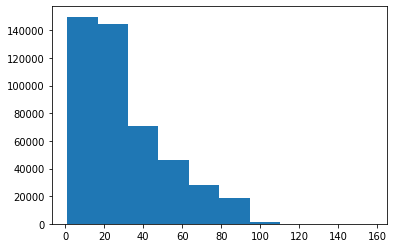

In [22]:
import matplotlib.pyplot as plt
print("총 데이터 수량 : ",fn_df['mean_len'].count())
print("평균길이 : ",fn_df['mean_len'].mean())

plt.hist(fn_df['mean_len'].tolist())
plt.show()

In [23]:
# fn_df['form']='수정할 문장 : '+fn_df['form']

In [24]:
fn_df.head(10)

form  \
492839                          응. 그 나는 있대. 그래 가지고 그냥 이상.   
125996                 크기는 일반 독서실인데 거기서 그 관리만 해 주는 거고? 어.   
53744     아 오히려 한국 친구를 못 사귀니까 외국 친군 쫌 더 편하지 않을까? 얘네는 더 그냥   
300563  슬 진짜 싫어할 걸 걔 걔는 엄청 싫어해 내 저번에 그 말 했 꺼냈는 적 있었는데 ...   
147341                         찜질방 가서 자는 거에 대해서도 이야길 했었는데   
279081        운동을 하는 애들도 살이 쪄 이게. 저절로 벌크업이 되는 딱 시기야. 그때가.   
380196                                       조용히 하면 안 되지.   
294884                        요금에 굉장히 그것보다 몇 배 많은 요금을 줘야만   
418821                                        엄청 급하게 나왔어.   
7512                                       그게 한 십 억? 팔 억?   

                                           corrected_form  mean_len  
492839                          응. 그 나는 있대. 그래 가지고 그냥 이상.        25  
125996                 크기는 일반 독서실인데 거기서 그 관리만 해 주는 거고? 어.        34  
53744     아 오히려 한국 친구를 못 사귀니까 외국 친군 쫌 더 편하지 않을까? 얘네는 더 그냥        47  
300563  슬 진짜 싫어할 걸 걔 걔는 엄청 싫어해 내 저번에 그 말 했 꺼냈는 적 있었는데 ...        63  
147341                         찜질방 가서 자는 거에 대해서도 이야길 했었는데        26  
279081        운동을 하는 애들도 살이 쪄 이게. 저절로 벌크업이 되는 딱 시기야. 그때가.        43  
380196                                       조용히 하면 안 되지.        12  
294884                        요금에 굉장히 그것보다 몇 배 많은 요금을 줘야만        27  
418821                                        엄청 급하게 나왔어.        11  
7512                                       그게 한 십 억? 팔 억?        14

In [25]:
# 14미만인건 따로 빼서 나중에 concat 시키자# ngram 도입

In [26]:
fn_df['mlen'] = list(map(lambda x:len(x.split(' ')),fn_df['form']))
fn_sho=fn_df[fn_df['mlen']<3]
fn_lon=fn_df[fn_df['mlen']>=3]

/tmp/ipykernel_39359/107797586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_df['mlen'] = list(map(lambda x:len(x.split(' ')),fn_df['form']))


In [27]:
# infer_text_smal=list(map(lambda x:len(x.split(' '))<14, fn_df.form))
# infer_text_smal[:5]

In [28]:
#fn_df[len(fn_df.form) < 14 ]

In [29]:
infer_text_arr = fn_lon['form'].to_list()
label_text_arr = fn_lon['corrected_form'].to_list()

In [30]:
infer_arr = []
label_arr = []

for it, lt in tqdm(list(zip(infer_text_arr, label_text_arr))):
    try:
        it = it.replace('\n', ' ')
        it = re.sub('[\s]+', ' ', it)
        it = it.strip()
        # it = it.replace(' ', '\n')
        it = it.split()

        lt = lt.replace('\n', ' ')
        lt = re.sub('[\s]+', ' ', lt)
        lt = lt.strip()
        # lt = lt.replace(' ', '\n')
        lt = lt.split()
    except:
        continue

    for tag, i1, i2, j1, j2  in dl.SequenceMatcher(None, it, lt).get_opcodes():
        # print(f'{tag:7}   it[{i1}:{i2}] --> l2[{j1}:{j2}] {it[i1:i2]!r:>6} --> {lt[j1:j2]!r}')
        # print(f'{tag:7}   it[{i1}:{i2}] --> lt[{j1}:{j2}] {it[i1:i2]!r} --> {lt[j1:j2]!r}')
        # infer_arr.append(it[i1:i2])
        # label_arr.append(lt[j1:j2])

        inf_arr = it[i1:i2]
        lab_arr = lt[j1:j2]

        inf_arr, lab_arr = align(inf_arr, lab_arr)
        # print(f'{tag:7}   it[{i1}:{i2}] --> lt[{j1}:{j2}] {len(inf_arr)} --> {len(lab_arr)}')
        infer_arr.extend(inf_arr)
        label_arr.extend(lab_arr)

100%|█████████████████████████████████████████████| 428317/428317 [00:28<00:00, 15205.36it/s]


In [31]:
len(infer_arr)

4149524

In [32]:
len(label_arr)

4149524

In [33]:
infer_arr[:5], label_arr[:5]

(['응.', '그', '나는', '있대.', '그래'], ['응.', '그', '나는', '있대.', '그래'])

In [34]:
infer_ng_arr = overlap2(infer_arr)
label_ng_arr = overlap2(label_arr)

In [35]:
len(infer_ng_arr), len(label_ng_arr)

(1383174, 1383174)

In [36]:
infer_ng_arr[:5]

['응. 그 나는 있대. 그래',
 '있대. 그래 가지고 그냥 이상.',
 '그냥 이상. 크기는 일반 독서실인데',
 '일반 독서실인데 거기서 그 관리만',
 '그 관리만 해 주는 거고?']

In [37]:
label_ng_arr[:5]

['응. 그 나는 있대. 그래',
 '있대. 그래 가지고 그냥 이상.',
 '그냥 이상. 크기는 일반 독서실인데',
 '일반 독서실인데 거기서 그 관리만',
 '그 관리만 해 주는 거고?']

In [38]:
infer_sho= fn_sho['form'].to_list()
label_sho = fn_sho['corrected_form'].to_list()

In [39]:
infer_ng_arr2=infer_ng_arr + infer_sho
label_ng_arr2=label_ng_arr+label_sho

In [40]:
infer_ng_arr2[-5:]

['아 좋아했어', '이게 인생을', '너무 비싸', '음 동기부여라기보다는', '총싸움 재밌지']

In [41]:
data = {'form': infer_ng_arr2, 'corrected_form': label_ng_arr2}
df_1 = pd.DataFrame(data)

In [42]:
len(df_1)

1414286

In [43]:
fn_df=df_1

In [44]:
len(fn_df)

1414286

In [45]:
fn_df.shape

(1414286, 2)

In [46]:
vocab = []
for i, row in tqdm(fn_df.iterrows(), total=df.shape[0]):
    form = row['form']
    corrected_form = row['corrected_form']
#     if '.' in form:
#         print(form)
#     elif '.' in corrected_form:
#         print(corrected_form)
    
#     if ',' in form:
#         print(form)
#     elif ',' in corrected_form:
#         print(corrected_form)
    # # '+' 확인
    # if '+' in form:
    #     print(form)
    # if '+' in corrected_form:
    #     print(corrected_form)
    # 개행문자 확인
#     if '\n' in form:
#         print(i, 'form', form)
#         print(i, 'corrected_form', corrected_form)
#         print('=' * 10)
        
#     if '\n' in form:
#         print(i, 'form', form)
#         print(i, 'corrected_form', corrected_form)
#         print('=' * 10)

    # 이상한애들 있는지 없는지
    # for trg in nfkd_target:
    #     if trg in form:
    #         # form = unicodedata.normalize('NFKD', form)
    #         form = form.replace(trg, '')
    #     elif trg in corrected_form:
    #         # corrected_form = unicodedata.normalize('NFKD', corrected_form_vocab)
    #         corrected_form = corrected_form.replace(trg, '')
    for char in form:
        vocab.append(char)
    for char in corrected_form:
        vocab.append(char)

vocab = sorted(set(vocab))

1414286it [03:39, 6457.81it/s]                                                               


In [47]:
print(vocab)

[' ', '!', ',', '.', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '가', '각', '간', '갇', '갈', '갉', '감', '갑', '값', '갓', '갔', '강', '갖', '갗', '같', '갚', '갛', '개', '객', '갠', '갤', '갬', '갭', '갯', '갰', '갱', '갸', '갹', '갼', '걀', '걉', '걋', '걍', '걔', '걘', '걜', '걧', '거', '걱', '건', '걷', '걸', '검', '겁', '것', '겄', '겅', '겉', '겋', '게', '겐', '겔', '겜', '겝', '겟', '겠', '겡', '겨', '격', '겪', '견', '결', '겸', '겹', '겼', '경', '곁', '계', '곈', '곌', '곗', '곘', '고', '곡', '곤', '곧', '골', '곪', '곯', '곰', '곱', '곳', '공', '곶', '과', '곽', '관', '괄', '괌', '괍', '괏', '광', '괘', '괜', '괞', '괭', '괴', '굉', '교', '굑', '굔', '굘', '굣', '굥', '구', '국', '군', '굳', '굴', '굵', '굶', '굼', '굽', '굿', '궁', '궂', '궈', '권', '궐', '궜', '궝', '궤', '귀', '귄', '귈', '귐', '귓', '규', '균', '귤', '귬', '그', '극', '근', '귿', '글', '긁', '긃', '금', '급', '긋', '긌', '긍', '기', '긱', '긴', '길', '김', '깁', '깃', '깄', '깅', '깊', '까', '깍', '깎', '깐', '깔', '깜', '깝', '깞', '깟', '깠', '깡', '깥', '깨', '깬', '깰', '깸',

In [48]:
raw_datasets = Dataset.from_pandas(fn_df).shuffle()

In [49]:
raw_datasets

Dataset({
    features: ['form', 'corrected_form'],
    num_rows: 1414286
})

In [50]:
medium_datasets = DatasetDict()
medium_datasets['train'] = raw_datasets

In [51]:
medium_datasets

DatasetDict({
    train: Dataset({
        features: ['form', 'corrected_form'],
        num_rows: 1414286
    })
})

In [52]:
# medium_datasets = medium_datasets.remove_columns('__index_level_0__')

In [53]:
medium_datasets

DatasetDict({
    train: Dataset({
        features: ['form', 'corrected_form'],
        num_rows: 1414286
    })
})

In [54]:
# datasets_train_test = medium_datasets["train"].train_test_split(test_size=int(args.test_size_ratio * len(df)))
# datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=int(args.test_size_ratio * len(df)))

# medium_datasets["train"] = datasets_train_validation["train"]
# medium_datasets["validation"] = datasets_train_validation["test"]
# medium_datasets["test"] = datasets_train_test["test"]

In [55]:
datasets_train_test = medium_datasets["train"].train_test_split(test_size=int(args.test_size_ratio * len(df)))

In [56]:
medium_datasets["train"] = datasets_train_test["train"]
medium_datasets["validation"] = datasets_train_test["test"]

In [57]:
medium_datasets["train"] = medium_datasets["train"].shuffle()
medium_datasets["validation"] = medium_datasets["validation"].shuffle()
# medium_datasets["test"] = medium_datasets["test"].shuffle()

In [58]:
medium_datasets

DatasetDict({
    train: Dataset({
        features: ['form', 'corrected_form'],
        num_rows: 1409086
    })
    validation: Dataset({
        features: ['form', 'corrected_form'],
        num_rows: 5200
    })
})

In [59]:
model_checkpoint = args.pretrained_model
# model_checkpoint = "t5-base"
# tokenizer = KoBERTTokenizer.from_pretrained(model_checkpoint)
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)

In [60]:
# tokens = tokenizer.tokenize("T5 GEC 모델 파인튜닝 합니다.")
# print(tokens)

# tokenizer.convert_tokens_to_ids(tokens)

In [61]:
# medium_datasets_cleaned = medium_datasets.filter(
#     lambda example: (len(example['form']) > 5) and
#     (len(example['corrected_form']) > 5)
# )

medium_datasets_cleaned = medium_datasets

In [62]:
medium_datasets_cleaned

DatasetDict({
    train: Dataset({
        features: ['form', 'corrected_form'],
        num_rows: 1409086
    })
    validation: Dataset({
        features: ['form', 'corrected_form'],
        num_rows: 5200
    })
})

In [63]:
def clean_text(text):
    # punctuation(문장부호 or 구두점)을 기준으로 개행
    # 즉, 한 문장 당 한 라인에 배치하도록 정제 하는 과정
    sentences = nltk.sent_tokenize(text.strip())
    sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
    sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                 if len(sent) > 0 and
                                 sent[-1] in string.punctuation]
    text_cleaned = "\n".join(sentences_cleaned_no_titles)
    return text_cleaned

def preprocess_data(examples):
    # texts_cleaned = [clean_text(text) for text in examples["form"]]
    texts_cleaned = [text for text in examples["form"]]
    # inputs = [prefix + text for text in texts_cleaned]
    inputs = [text for text in texts_cleaned]
    
    model_inputs = tokenizer(inputs, max_length=args.max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["corrected_form"], max_length=args.max_target_length, 
                           truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [64]:
tokenized_datasets = medium_datasets_cleaned.map(preprocess_data,
                                                 batched=True)

  0%|          | 0/1410 [00:00<?, ?ba/s]

/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3542: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?ba/s]

In [65]:
tokenized_datasets['train']['form'][:2]

['예전에 취업 스터디 할 때', '앞 앞으로 나와가지구. 아니야. 독서실도']

In [66]:
tokenized_datasets['train']['corrected_form'][:2]

['예전에 취업 스터디 할 때', '앞 앞으로 나와가지구. 아니야. 독서실도']

In [67]:
data_collator = DataCollatorForSeq2Seq(tokenizer)

In [68]:
# metric = load_metric("rouge")
cer_metric = load_metric("cer")

In [69]:
'''
-100을 pad_token_id로 바꾸고 id를 디코딩하여 인코딩된 레이블을 원래 문자열로 다시 변환한다.
그리고 동시에 연속적인 토큰이 CTC 스타일의 동일한 토큰으로 그룹화되지 않도록 한다.
'''
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    # decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
    #                   for pred in decoded_preds]
    # print('decoded_preds:', decoded_preds[:5])
    # decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
    #                   for label in decoded_labels]
    # print('decoded_labels:', decoded_labels[:5])
    for pred, label in zip(decoded_preds, decoded_labels):
        print('_pred:', pred)
        print('label:', label)
        print('=' * 80)
    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    # wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}
    # return {"wer": wer}

In [70]:
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
#     # Replace -100 in the labels as we can't decode them.
#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
#     # Rouge expects a newline after each sentence
#     decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
#                       for pred in decoded_preds]
#     decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
#                       for label in decoded_labels]
    
#     # Compute ROUGE scores
#     result = metric.compute(predictions=decoded_preds, references=decoded_labels,
#                             use_stemmer=True)

#     # Extract ROUGE f1 scores
#     result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
#     # Add mean generated length to metrics
#     prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
#                       for pred in predictions]
#     result["gen_len"] = np.mean(prediction_lens)
    
#     return {k: round(v, 4) for k, v in result.items()}

In [71]:
# import wandb

# wandb.login()
# wandb.init(project='t5-north-ft')

In [72]:
# model_name = "t5-base-medium-title-generation"
model_dir = args.output_dir
number = 2000

training_args = Seq2SeqTrainingArguments(
    model_dir,
    evaluation_strategy="steps",
    eval_steps=number,
    # eval_steps=5,
    logging_strategy="steps",
    logging_steps=number,
    save_strategy="steps",
    save_steps=number,
    # save_steps=5,
    # learning_rate=4e-8,
    learning_rate=4e-5,
    per_device_train_batch_size=args.batch_size,
    per_device_eval_batch_size=args.batch_size,
    weight_decay=0.01,
    num_train_epochs=10, # 3에서 1로 수정
    predict_with_generate=True,
    # fp16=True,
    save_total_limit=10,
    # eval_accumulation_steps=1,
    warmup_steps=number,
    load_best_model_at_end=True,
    # metric_for_best_model="rouge1",
    # report_to="wandb"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [73]:
# Function that returns an untrained model to be trained
def model_init():
    return T5ForConditionalGeneration.from_pretrained(model_checkpoint)
    # return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
    # return BertModel.from_pretrained(model_checkpoint)


trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1)],
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--KETI-AIR--ke-t5-large-ko/snapshots/f9fd25f4a2ec524e0ec57f17a5fc0c642c75dc61/config.json
Model config T5Config {
  "_name_or_path": "hf/ke-t5-large-ko",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2816,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.0,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 24,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.23.1",
  "use_cache": true,
  "vocab_size": 64128
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--KETI-AIR

In [74]:
trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--KETI-AIR--ke-t5-large-ko/snapshots/f9fd25f4a2ec524e0ec57f17a5fc0c642c75dc61/config.json
Model config T5Config {
  "_name_or_path": "hf/ke-t5-large-ko",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2816,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.0,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 24,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.23.1",
  "use_cache": true,
  "vocab_size": 64128
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--KETI-AIR

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form. If form, corrected_form are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5200
  Batch size = 8


_pred: 이 학년 삼 학년 학년 학년 학년 학년 charming charming charming charming charming charming charming charming charming charming charming
label: 이 학년 삼 학년 아니면
_pred: 어 작년 눈눈눈눈눈은 돌아올고 원래
label: 어. 예전 눈으로 돌아온다고? 원래
_pred: 진짜 뭐 해보가 그거는 그거는 그거는 그거는 그거는 그거는 그거는 그거는 그거는 그거는 그거는 그거는 그거는 그거는 그거는
label: 진짜. 뭐 하기가 한국에서 하기가
_pred: 게 근데 갑자기 갑자기 확 그래가지고
label: 게 근데 갑자기 확 그래가지고
_pred: 동안 인생이 뛰웠아아아아아아아아아아아이이이이
label: 동안 아닌가? 선생님께서 많이 신경
_pred: 됐니? 아 그 이미 다
label: 됐니? 아 그 이미 다
_pred: 학년 주 주말 하긴 안 안 안 안 안 안 안 안 안 안 안 안 안 안 안
label: 첫째 주 주말 하긴 밖에
_pred: 한 번도 본 적이 없어.
label: 한 번도 본 적이 없어.
_pred: 많이 먹은 밥 밥이 뭐야? 하면
label: 많이 먹은 밥이 뭐야? 하면
_pred: 그러긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴 하긴
label: 그러긴 하지.
_pred: 한 번 해보 만 해.
label: 한 번 해볼 만해. 그니까는
_pred: 싶어 했 했거든. 근데 엄마가
label: 싶다 했 했거든. 근데 엄마가
_pred: 그랬거든. 그 그니까 너무 어 어어어어어어어어어어어어
label: 그랬거든. 그 그니까 너무 어중간해질
_pred: 뭐야년이.서 말을 해 그러면은
label: 뭐야? 이래서 말을 해. 그러면은
_pred: 그 자로로드로드로드로드로드로드로드로드로드로드로드로드로드로드로드로드
label: 그 자이로드롭? 그것 그것도 탔어?
_pred: 몰라. 엄마가 엄마가 못먹었어.
label: 

Saving model checkpoint to ./pko_save/pko-5gram/checkpoint-2000
Configuration saved in ./pko_save/pko-5gram/checkpoint-2000/config.json
Model weights saved in ./pko_save/pko-5gram/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-5gram/checkpoint-2000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-5gram/checkpoint-2000/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form. If form, corrected_form are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5

_pred: 이 학년 삼 학년? 아니면
label: 이 학년 삼 학년 아니면
_pred: 어 예전 눈으론 돌아온다고 원래
label: 어. 예전 눈으로 돌아온다고? 원래
_pred: 진짜 뭐 하기가 한국에서 하기가
label: 진짜. 뭐 하기가 한국에서 하기가
_pred: 게 근데 갑자기 확 그래가지고
label: 게 근데 갑자기 확 그래가지고
_pred: 동안 지난 뛰고분에아아가 가 선생님이께서 많이 신경
label: 동안 아닌가? 선생님께서 많이 신경
_pred: 됐니? 아 그 이미 다
label: 됐니? 아 그 이미 다
_pred: 첫째 주 주말 하긴 밖에
label: 첫째 주 주말 하긴 밖에
_pred: 한 번도 본 적이 없어.
label: 한 번도 본 적이 없어.
_pred: 많이 먹은 밥이 뭐야? 하면
label: 많이 먹은 밥이 뭐야? 하면
_pred: 그러긴 하지.
label: 그러긴 하지.
_pred: 한 번 해볼 만해. 그까는
label: 한 번 해볼 만해. 그니까는
_pred: 싶다 했 했거든. 근데 엄마가
label: 싶다 했 했거든. 근데 엄마가
_pred: 그랬거든. 그 그니까 너무 어중간해질
label: 그랬거든. 그 그니까 너무 어중간해질
_pred: 뭐야 이래서 말을 해 그러면은
label: 뭐야? 이래서 말을 해. 그러면은
_pred: 그 자이로드로드로드로 그거 그거 탔어.
label: 그 자이로드롭? 그것 그것도 탔어?
_pred: 몰라. 엄마가 못 먹게 했어.
label: 몰라. 엄마가 못 먹게 했어.
_pred: 때마다 그 청바질 입고 있는
label: 때마다 그 청바질 입고 있는
_pred: 그걸로 샀어. 어, 안 망친
label: 그걸로 샀어. 어, 안 망친
_pred: 티켓팅 직전에
label: 티켓팅 직전에.
_pred: 그대로 싱어송라이터잖아. 나 중국어 안
label: 그대로 싱어송라이터잖아. 나 일본어 안
_pred: 진짜 비행시 비행? 실력인가 어 돌잔치가
label: 진짜? 비행 시비행실력인가? 어 돌잔치가

Saving model checkpoint to ./pko_save/pko-5gram/checkpoint-4000
Configuration saved in ./pko_save/pko-5gram/checkpoint-4000/config.json
Model weights saved in ./pko_save/pko-5gram/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-5gram/checkpoint-4000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-5gram/checkpoint-4000/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form. If form, corrected_form are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5

_pred: 이 학년 삼 학년 아니면
label: 이 학년 삼 학년 아니면
_pred: 어 예전 눈으론 돌아온다고 원래
label: 어. 예전 눈으로 돌아온다고? 원래
_pred: 진짜 뭐 하기가 한국에서 하기가
label: 진짜. 뭐 하기가 한국에서 하기가
_pred: 게 근데 갑자기 확 그래가지고
label: 게 근데 갑자기 확 그래가지고
_pred: 동안 시절뛰고저녁아아아닌가 가선생님께서 많이 신경
label: 동안 아닌가? 선생님께서 많이 신경
_pred: 됐니? 아 그 이미 다
label: 됐니? 아 그 이미 다
_pred: 첫째 주 주말 하긴 밖에
label: 첫째 주 주말 하긴 밖에
_pred: 한 번도 본 적이 없어.
label: 한 번도 본 적이 없어.
_pred: 많이 먹은 밥이 뭐야? 하면
label: 많이 먹은 밥이 뭐야? 하면
_pred: 그러긴 하지.
label: 그러긴 하지.
_pred: 한 번 해볼 만해. 그까는
label: 한 번 해볼 만해. 그니까는
_pred: 싶다 했 했거든. 근데 엄마가
label: 싶다 했 했거든. 근데 엄마가
_pred: 그랬거든. 그 그니까 너무 어중간해질
label: 그랬거든. 그 그니까 너무 어중간해질
_pred: 뭐야 이래서 말을 해 그러면은
label: 뭐야? 이래서 말을 해. 그러면은
_pred: 그 자르로드로드로드로드로드로드로드로드로드드 그것도 탔어
label: 그 자이로드롭? 그것 그것도 탔어?
_pred: 몰라. 엄마가 못 먹게 했어.
label: 몰라. 엄마가 못 먹게 했어.
_pred: 때마다 그 청바질 입고 있는
label: 때마다 그 청바질 입고 있는
_pred: 그걸로 샀어. 어, 안 망친
label: 그걸로 샀어. 어, 안 망친
_pred: 티켓팅 직전에 직전에
label: 티켓팅 직전에.
_pred: 그대로 싱어송라이터잖아. 나 일본어 안
label: 그대로 싱어송라이터잖아. 나 일본어 안
_pred: 진짜 비행시 비행 실력인가 어 돌잔치가
label: 진짜? 비행 시비행실력

Saving model checkpoint to ./pko_save/pko-5gram/checkpoint-6000
Configuration saved in ./pko_save/pko-5gram/checkpoint-6000/config.json
Model weights saved in ./pko_save/pko-5gram/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-5gram/checkpoint-6000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-5gram/checkpoint-6000/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form. If form, corrected_form are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5

_pred: 이 학년 삼 학년 아니면
label: 이 학년 삼 학년 아니면
_pred: 어? 예전은 돌아온다고 원래
label: 어. 예전 눈으로 돌아온다고? 원래
_pred: 진짜 뭐 하기가? 한국에서 하기가
label: 진짜. 뭐 하기가 한국에서 하기가
_pred: 게 근데 갑자기 확 그래가지고
label: 게 근데 갑자기 확 그래가지고
_pred: 동안 뛰고동안?????? 많이 신경
label: 동안 아닌가? 선생님께서 많이 신경
_pred: 됐니? 아 그 이미 다
label: 됐니? 아 그 이미 다
_pred: 첫째 주 주말 하긴 밖에
label: 첫째 주 주말 하긴 밖에
_pred: 한 번도 본 적이 없어.
label: 한 번도 본 적이 없어.
_pred: 많이 먹은 밥이 뭐야? 하면
label: 많이 먹은 밥이 뭐야? 하면
_pred: 그러긴 하지.
label: 그러긴 하지.
_pred: 한 번 해볼 만해. 그니까는
label: 한 번 해볼 만해. 그니까는
_pred: 싶다 했 했거든. 근데 엄마가
label: 싶다 했 했거든. 근데 엄마가
_pred: 그랬거든. 그 그니까 너무 어중간해질
label: 그랬거든. 그 그니까 너무 어중간해질
_pred: 뭐야 이래서 말을 해 그러면은
label: 뭐야? 이래서 말을 해. 그러면은
_pred: 그? 아니? 그것 그것도 탔어?
label: 그 자이로드롭? 그것 그것도 탔어?
_pred: 몰라. 엄마가 못 먹게 했어.
label: 몰라. 엄마가 못 먹게 했어.
_pred: 때마다 그 청바질 입고 있는
label: 때마다 그 청바질 입고 있는
_pred: 그걸로 샀어. 어, 안 망친
label: 그걸로 샀어. 어, 안 망친
_pred: 티켓팅 직전에
label: 티켓팅 직전에.
_pred: 그대로 싱어송라이터잖아. 나 일본어 안
label: 그대로 싱어송라이터잖아. 나 일본어 안
_pred: 진짜 비행시 실력인가? 어, 돌잔치가
label: 진짜? 비행 시비행실력인가? 어 돌잔치가
_pred: 난 그 새로 들

Saving model checkpoint to ./pko_save/pko-5gram/checkpoint-8000
Configuration saved in ./pko_save/pko-5gram/checkpoint-8000/config.json
Model weights saved in ./pko_save/pko-5gram/checkpoint-8000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-5gram/checkpoint-8000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-5gram/checkpoint-8000/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form. If form, corrected_form are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5

_pred: 이 학년 삼 학년 아니면
label: 이 학년 삼 학년 아니면
_pred: 어 예전 눈으론 돌아온다고 원래
label: 어. 예전 눈으로 돌아온다고? 원래
_pred: 진짜 뭐 하기가 한국에서 하기가
label: 진짜. 뭐 하기가 한국에서 하기가
_pred: 게 근데 갑자기 확 그래가지고
label: 게 근데 갑자기 확 그래가지고
_pred: 동안 시절뛰고동안. 가선생님께서 많이 신경
label: 동안 아닌가? 선생님께서 많이 신경
_pred: 됐니? 아 그 이미 다
label: 됐니? 아 그 이미 다
_pred: 첫째 주 주말 하긴 밖에
label: 첫째 주 주말 하긴 밖에
_pred: 한 번도 본 적이 없어.
label: 한 번도 본 적이 없어.
_pred: 많이 먹은 밥이 뭐야? 하면
label: 많이 먹은 밥이 뭐야? 하면
_pred: 그러긴 하지.
label: 그러긴 하지.
_pred: 한 번 해볼 만해. 그까는
label: 한 번 해볼 만해. 그니까는
_pred: 싶다 했 했거든. 근데 엄마가
label: 싶다 했 했거든. 근데 엄마가
_pred: 그랬거든. 그 그니까 너무 어중간해질
label: 그랬거든. 그 그니까 너무 어중간해질
_pred: 뭐야 이래서 말을 해 그러면은
label: 뭐야? 이래서 말을 해. 그러면은
_pred: 그 자이로드로드딥 그것 그것도 탔어.
label: 그 자이로드롭? 그것 그것도 탔어?
_pred: 몰라. 엄마가 못 먹게 했어.
label: 몰라. 엄마가 못 먹게 했어.
_pred: 때마다 그 청바질 입고 있는
label: 때마다 그 청바질 입고 있는
_pred: 그걸로 샀어. 어, 안 망친
label: 그걸로 샀어. 어, 안 망친
_pred: 티켓팅 직전에
label: 티켓팅 직전에.
_pred: 그대로 싱어송라이터잖아. 나 일본어 안
label: 그대로 싱어송라이터잖아. 나 일본어 안
_pred: 진짜비행시 비행 실력인가? 어. 돌잔치가
label: 진짜? 비행 시비행실력인가? 어 돌잔치가
_pred:

Saving model checkpoint to ./pko_save/pko-5gram/checkpoint-10000
Configuration saved in ./pko_save/pko-5gram/checkpoint-10000/config.json
Model weights saved in ./pko_save/pko-5gram/checkpoint-10000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-5gram/checkpoint-10000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-5gram/checkpoint-10000/special_tokens_map.json
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: form, corrected_form. If form, corrected_form are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num example

_pred: 이 학년 삼 학년 아니면
label: 이 학년 삼 학년 아니면
_pred: 어 예전 눈으론 돌아온다고 원래
label: 어. 예전 눈으로 돌아온다고? 원래
_pred: 진짜 뭐 하기가 한국에서 하기가
label: 진짜. 뭐 하기가 한국에서 하기가
_pred: 게 근데 갑자기 확 그래가지고
label: 게 근데 갑자기 확 그래가지고
_pred: 동안 시절뛰럭고동안아닌가 가선생님께서 많이 신경
label: 동안 아닌가? 선생님께서 많이 신경
_pred: 됐니? 아 그 이미 다
label: 됐니? 아 그 이미 다
_pred: 첫째 주 주말 하긴 밖에
label: 첫째 주 주말 하긴 밖에
_pred: 한 번도 본 적이 없어.
label: 한 번도 본 적이 없어.
_pred: 많이 먹은 밥이 뭐야? 하면
label: 많이 먹은 밥이 뭐야? 하면
_pred: 그러긴 하지.
label: 그러긴 하지.
_pred: 한 번 해볼 만해. 그까는
label: 한 번 해볼 만해. 그니까는
_pred: 싶다 했 했거든. 근데 엄마가
label: 싶다 했 했거든. 근데 엄마가
_pred: 그랬거든. 그 그니까 너무 어중간해질
label: 그랬거든. 그 그니까 너무 어중간해질
_pred: 뭐야 이래서 말을 해 그러면은
label: 뭐야? 이래서 말을 해. 그러면은
_pred: 그 자이로드로드로드로드드 그것도 탔어.
label: 그 자이로드롭? 그것 그것도 탔어?
_pred: 몰라. 엄마가 못 먹게 했어.
label: 몰라. 엄마가 못 먹게 했어.
_pred: 때마다 그 청바질 입고 있는
label: 때마다 그 청바질 입고 있는
_pred: 그걸로 샀어. 어, 안 망친
label: 그걸로 샀어. 어, 안 망친
_pred: 티켓팅 직전에
label: 티켓팅 직전에.
_pred: 그대로 싱어송라이터잖아. 나 일본어 안
label: 그대로 싱어송라이터잖아. 나 일본어 안
_pred: 진짜비행시 비행 실력인가? 어 돌잔치가
label: 진짜? 비행 시비행실력인가? 어 돌잔치가
_pr

Saving model checkpoint to ./pko_save/pko-5gram/checkpoint-12000
Configuration saved in ./pko_save/pko-5gram/checkpoint-12000/config.json
Model weights saved in ./pko_save/pko-5gram/checkpoint-12000/pytorch_model.bin
tokenizer config file saved in ./pko_save/pko-5gram/checkpoint-12000/tokenizer_config.json
Special tokens file saved in ./pko_save/pko-5gram/checkpoint-12000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./pko_save/pko-5gram/checkpoint-10000 (score: 0.46072426438331604).


TrainOutput(global_step=12000, training_loss=2.4981019897460937, metrics={'train_runtime': 25265.4507, 'train_samples_per_second': 557.713, 'train_steps_per_second': 69.714, 'total_flos': 4448964445765632.0, 'train_loss': 2.4981019897460937, 'epoch': 0.07})

**Issue: nan Loss**
1. tokenizer & model: no sol
    - tokenizer: AutoTokenizer -> T5tokenizer , AutoModelForSeq2SeqLM -> T5ForConditionalGeneration
2. lr: no sol
    - 4e-5 -> 4e-8
3. prefix: no sol
    - 프리트레이닝 태스크와 직접 관련 태스크 아니면 no prefix여도 괜찮다는 포스팅 본 적 있음
    - 하지만, 어떤 포스팅은 직접 관련 태스크에 해당하는 prefix를 꼭 추가하도록 안내함
        - https://discuss.huggingface.co/t/finetune-bart-for-text-summary-has-nan-loss/10040
    - GEC를 summarization과 비슷한 맥락으로 간주하고 테스트 진행
    - prfix = "summarize: "
    - inputs = [prefix + text for text in texts_cleaned]
4. fp16: sol!!!!
    - There is something worng with fp16 in T5 fine-tuning.
        - https://discuss.huggingface.co/t/gradient-overflow-when-fine-tune-t5-on-cnn-dm-dataset/513
    - turn off

# **modelling**
1. model.freeze_feature_encoder()